In [2]:
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from scipy.cluster.vq import whiten, kmeans2

In [5]:
def call_api(uri, result_key):
    json = {}
    try:
        json = requests.get(uri, headers = { 'X-Auth-Token': 'c52b7825851b4357af3e06c1888152f0' }).json()
        return json[result_key]
    except:
        print(json)
        return None

In [6]:
teams = call_api('http://api.football-data.org/v1/soccerseasons/439/teams', 'teams')
teams.extend(call_api('http://api.football-data.org/v1/soccerseasons/440/teams', 'teams'))

In [7]:
def is_looser(team, fixture):
    scored_goals = 0
    missed_goals = 0
    
    def goals_count(time_part):
        result = {}
        if team['name'] == fixture['homeTeamName']:
            result['scored'] = time_part['goalsHomeTeam'] if time_part['goalsHomeTeam'] else 0
            result['missed'] = time_part['goalsAwayTeam'] if time_part['goalsAwayTeam'] else 0
        else:
            result['scored'] = time_part['goalsAwayTeam'] if time_part['goalsAwayTeam'] else 0
            result['missed'] = time_part['goalsHomeTeam'] if time_part['goalsHomeTeam'] else 0
        return result
    
    time_parts = [f['result'], ]
    if 'extraTime' in f['result']:
        time_parts.append(f['result']['extraTime'])
    if 'penaltyShootout' in f['result']:
        time_parts.append(f['result']['penaltyShootout'])
                          
    for time in time_parts:
        goals = goals_count(time)
        scored_goals += goals['scored']
        missed_goals += goals['missed']
   
    if scored_goals >= missed_goals:
        return False
    else: return True
    
    
for team in teams:
    looses = 0
    fixtures = call_api(team['_links']['fixtures']['href'], 'fixtures')
    if not fixtures:
        continue
    for f in fixtures:
        looses += is_looser(team, f)
#     print('Team "{}", {} matches, {} looses'.format(team['name'], len(fixtures), looses))
    team['looses'] = looses
    team['fixtures'] = fixtures

In [8]:
team_for_pd = []
for team in teams:
    if team['fixtures']:
        team_for_pd.append({'name': team['name'], 
                            'fixtures': len(team['fixtures']), 
                            'looses': team['looses']
                           })

In [9]:
teams_pd = pd.DataFrame(team_for_pd)

In [10]:
del teams_pd['name']
whitened = whiten(teams_pd.as_matrix())

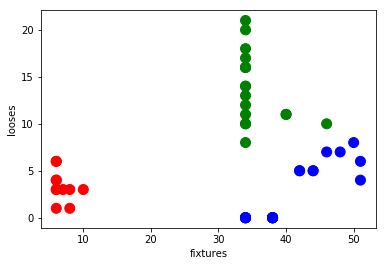

In [84]:
centroids, cluster_map = kmeans2(whitened, 3)
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map]
teams_pd.plot.scatter(x='fixtures', y='looses', c=colors, s=100)

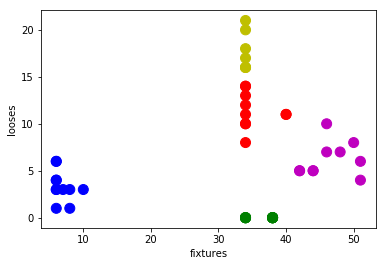

In [87]:
centroids, cluster_map = kmeans2(whitened, 5)
colors = [colors_map[c] for c in cluster_map]
teams_pd.plot.scatter(x='fixtures', y='looses', c=colors, s=100)